# 迁移学习教程

**作者**: [Sasank Chilamkurthy](https://chsasank.github.io)

在这个教程中，我们将学习如何使用迁移学习训练网络。
更多有关迁移学习的内容可参阅[cs231n notes](https://cs231n.github.io/transfer-learning/)

一些来自上述笔记的摘要，

> 在实践中，很少有人从头开始训练整个卷积网络（随机初始化），因为拥有足够大小的数据集的情况是相对罕见的。
> 相反，通常在非常大的数据集（例如ImageNet，其包含具有1000个类别的120万个图像）上预先训练ConvNet，然后使用ConvNet作为后续任务的初始化或固定特征提取器。


下面是两种主要的迁移学习场景：

- **卷积的微调**: 这种情况下，不用随机初始化，而是从一个预训练网络（例如在 imagenet 1000 数据集上训练过的）开始初始化网络。
  后面的训练照常进行。
- **卷积网络作为固定特征提取器**: 这种方式下，冻结除了最后一个全连接层之外的所有网络的权重。
  最后一个全连接层被替换为随机权重，且只有这一个层被训练。




In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 加载数据

我们用 `torchvision`和`torch.utils.data`包加载数据

这里要解决的问题是训练一个模型用于对**蚂蚁**和**蜜蜂**进行分类。
蚂蚁和蜜蜂分别有到大约120个训练图线，75个验证图像。
按照一般标准，如果从头开始训练的话，这个数据集是很小的。
不过我们使用的是迁移学习，模型应该能够得到足够好的泛化结果。

这个数据集是imagenet的一个非常小的子集。

!!! note
    从<https://download.pytorch.org/tutorial/hymenoptera_data.zip>下载数据，并解压到当前目录下的`data`子目录。



In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 显示少量图像

我们显示少量图像，以便理解数据增强。



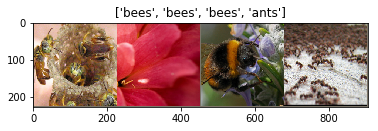

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 训练模型

现在，我们编写用于训练模型的通用函数。在函数中，我们需要：

- 安排学习率
- 保存最好的模型

下面代码中的`scheduler`参数是来自`torch.optim.lr_scheduler`的 LR scheduler 对象。



In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 显示模型的预测结果

用于显示少量图像预测结果的通用函数




In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 微调卷积网络

加载预训练模型，并重置最后的全连接层。




In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 训练与评估

在CPU上大约需要15-25分钟，在GPU上需要大约不到一分钟。




In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6645 Acc: 0.6803
val Loss: 0.9809 Acc: 0.6340

Epoch 1/24
----------
train Loss: 0.5326 Acc: 0.8115
val Loss: 0.1608 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.4786 Acc: 0.8115
val Loss: 0.2549 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4241 Acc: 0.8361
val Loss: 0.2157 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4840 Acc: 0.8115
val Loss: 0.2490 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3529 Acc: 0.8607
val Loss: 0.3553 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5773 Acc: 0.7623
val Loss: 0.2592 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.4033 Acc: 0.8279
val Loss: 0.2284 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3246 Acc: 0.8607
val Loss: 0.2262 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2883 Acc: 0.8975
val Loss: 0.2000 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2666 Acc: 0.9057
val Loss: 0.1866 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3363 Acc: 0.8402
val Loss: 0.1922 Acc: 0.9412

Ep

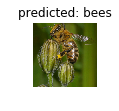

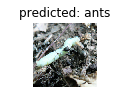

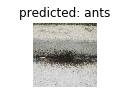

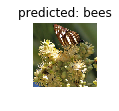

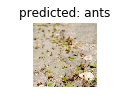

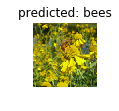

In [8]:
visualize_model(model_ft)

## 卷积网络作为固定特征提取器

要冻结出最后一层之外的整个网络，我们得设置`requires_grad == False`来冻结参数，这样一来，`backward()`就不再计算梯度。
阅读这个文档可以获得更多信息：<https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>。.




In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 训练与评估


在CPU上需要的时间大约是上个场景的一半，这是因为不需要为大多数网络计算梯度。不过，前向还是要计算的。




In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6012 Acc: 0.6926
val Loss: 0.2920 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5843 Acc: 0.7500
val Loss: 0.1724 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5340 Acc: 0.7500
val Loss: 0.1489 Acc: 0.9673

Epoch 3/24
----------
train Loss: 0.4718 Acc: 0.8074
val Loss: 0.1579 Acc: 0.9673

Epoch 4/24
----------
train Loss: 0.5471 Acc: 0.7746
val Loss: 0.1791 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.6842 Acc: 0.7213
val Loss: 0.4588 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.5558 Acc: 0.7664
val Loss: 0.1744 Acc: 0.9673

Epoch 7/24
----------
train Loss: 0.2958 Acc: 0.8770
val Loss: 0.1850 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3071 Acc: 0.8607
val Loss: 0.1790 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.4278 Acc: 0.8320
val Loss: 0.1905 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2871 Acc: 0.8934
val Loss: 0.1990 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3389 Acc: 0.8566
val Loss: 0.1733 Acc: 0.9608

Ep

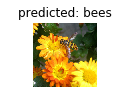

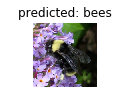

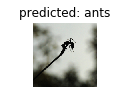

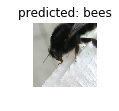

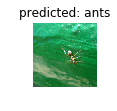

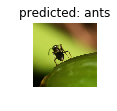

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()